<a href="https://colab.research.google.com/github/aryashivakumar/dataScience/blob/main/Unit3/AryaKumarUnit3Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**

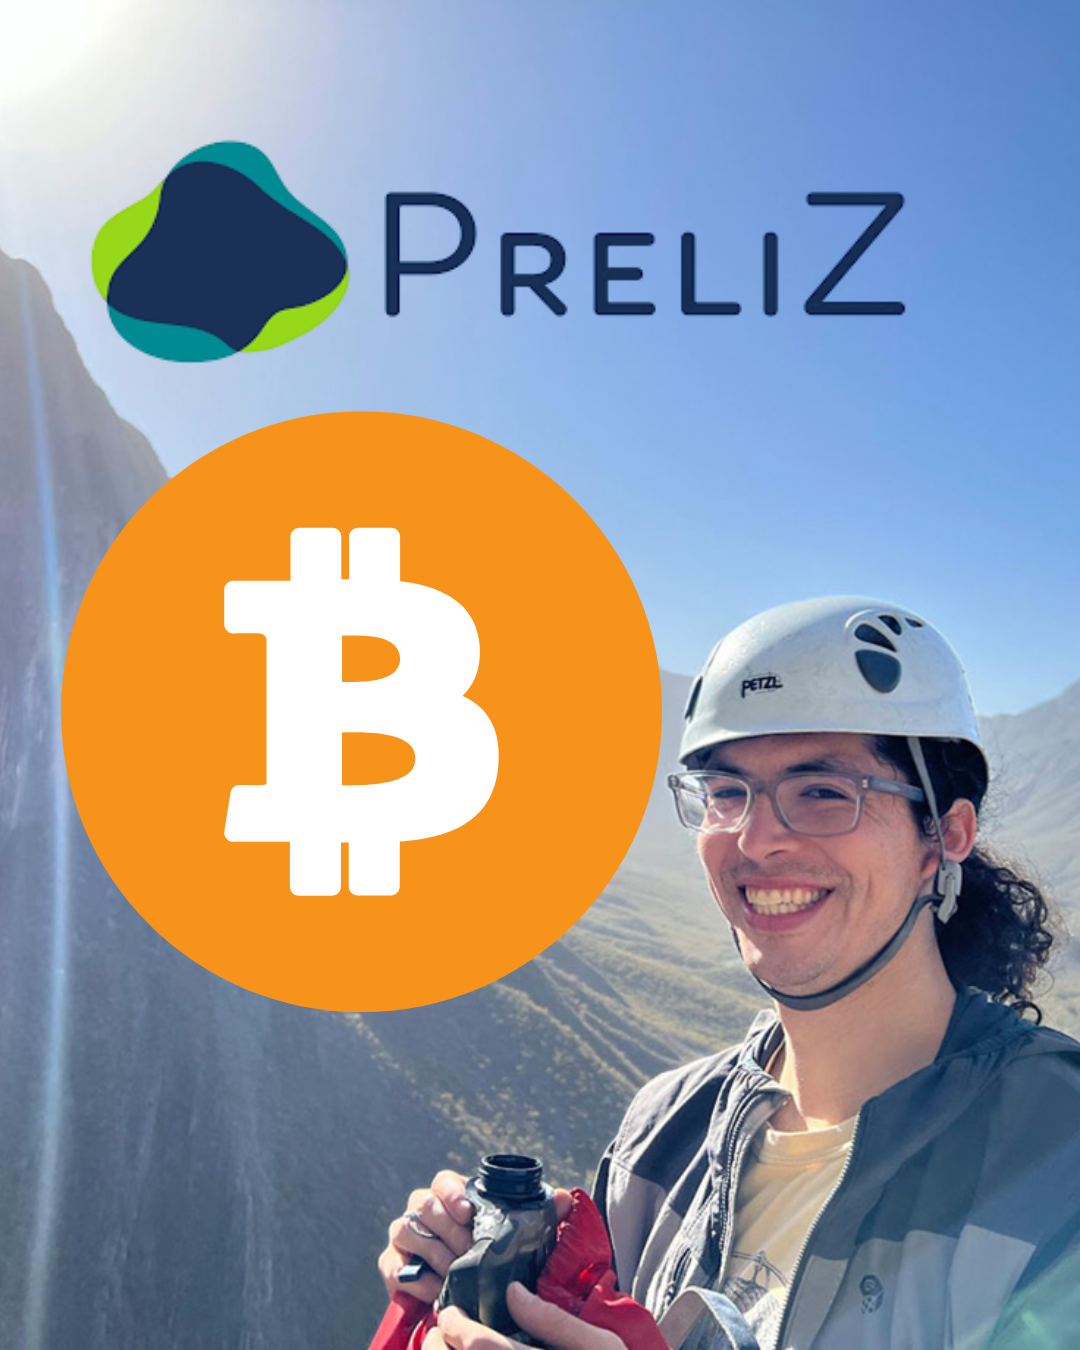

In [47]:
!pip install preliz

For my Unit 3 Project, I will be utilizing the price of Bitcoin's price on a given day. Bitcoin (abbreviation: BTC; sign: ₿) is the first decentralized cryptocurrency. Based on a free-market ideology, bitcoin was invented in 2008 when an unknown entity published a white paper under the pseudonym of Satoshi Nakamoto. Bitcoin works through the collaboration of computers, each of which acts as a node in the peer-to-peer bitcoin network. Each node maintains an independent copy of a public distributed ledger of transactions, called a blockchain, without central oversight. (Wikipedia)

Over the past few years, Bitcoin has seen immense growth from a mere few hundred dollars all the way to over a hundred thousand. The model I plan to create will utilize the past 6 months of bitcoin to find a distrbution for the price of Bitcoin.

In [48]:
import preliz as pz

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

## **Data**

In order to solve this problem of predicting the future of Bitcoins closing prices, I plan to utilize the past 6 months as this time period is post tarrifs period.

After I found the data for the past 6 months of closing prices for Bitcoin, I downloaded them and modified the data in a google spreadsheet in order to only contain the closing data for the past 6 months. After this I downloaded the spreadsheet as a csv file and uploaded it to my Github under Unit 3, and then utilized it in this Colab file.

In [50]:
data1 = "https://raw.githubusercontent.com/aryashivakumar/dataScience/refs/heads/main/Unit3/Bitcoin6monthsPriceData%20-%20Bitcoin%20Historical%20Data%20(1).csv"
DataSet = pd.read_csv(data1)
dataFinal = DataSet["Price"]
dataFinal

,Price
0,"117,288.80"
1,"114,048.50"
2,"114,357.50"
3,"112,174.60"
4,"109,652.80"
...,...
179,"83,552.10"
180,"83,866.70"
181,"83,159.40"
182,"82,525.00"


(array([19., 18., 18., 18., 18., 19., 18., 19., 18., 19.]),
 array([  0. ,  18.2,  36.4,  54.6,  72.8,  91. , 109.2, 127.4, 145.6,
        163.8, 182. ]),
 <BarContainer object of 10 artists>)

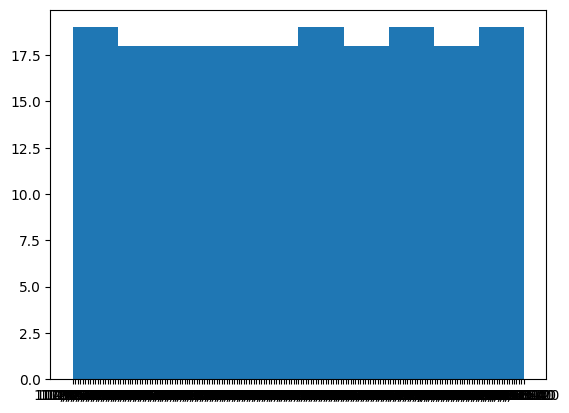

In [51]:
plt.hist(dataFinal)


The histogram above showcases a visual of what the closing data looks like. My data is extremeley uniform, therefore I plan to use a uniform prior.

# **PRIOR**

Uniform Prior, I don't have enough context or know enough about the market to use a more specific dist. The histogram also showcased a very uniform distribution overall.

np.float64(99817.95)

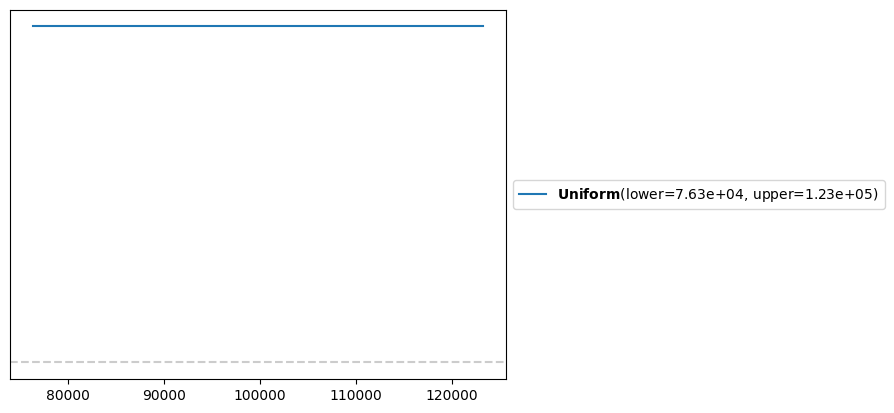

In [52]:
pz.Uniform(76312.50,123323.40).plot_pdf()
pz.Uniform(76312.50,123323.40).mean()

PRIOR 2

For my prior for my standard deviation, I will be utilizing the half normal distribution. This is because the half normal only has positive vales, and my SD is always positive.

<Axes: >

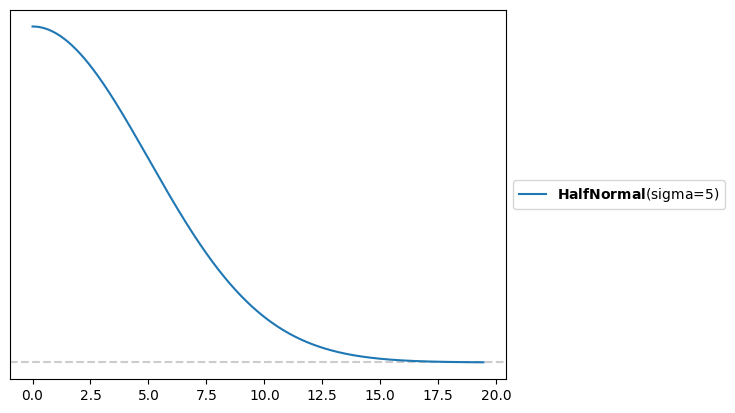

In [53]:
pz.HalfNormal(sigma =  5).plot_pdf()

## **Initial Model**

Now that we have all the priors established, I will incorporate them all together for my final model. mu is my mean , sigma is my standard deviation. My observed is simply my stock data. The distribution I plan to use is the pm.Normal as this utilizes my two priors.

In [ ]:
# Convert the dataFinal series to numeric, removing commas
dataFinal_numeric = pd.to_numeric(dataFinal.str.replace(',', ''), errors='coerce')

# Drop any rows with NaN values that resulted from coercion
dataFinal_numeric = dataFinal_numeric.dropna()

with pm.Model() as model_Bitcoin:
    # I have no idea where the mean should be, but its reasonalbe to assume
    # its between our lowest and highest values recorded
    μ = pm.Uniform('μ', lower=76312.50, upper=123323.40)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=5)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=dataFinal_numeric)
    idata_bitcoin= pm.sample()

In [55]:
# Convert the dataFinal series to numeric, removing commas
dataFinal_numeric = pd.to_numeric(dataFinal.str.replace(',', ''), errors='coerce')

# Drop any rows with NaN values that resulted from coercion
dataFinal_numeric = dataFinal_numeric.dropna()

display(dataFinal_numeric)

,Price
0,117288.8
1,114048.5
2,114357.5
3,112174.6
4,109652.8
...,...
179,83552.1
180,83866.7
181,83159.4
182,82525.0


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

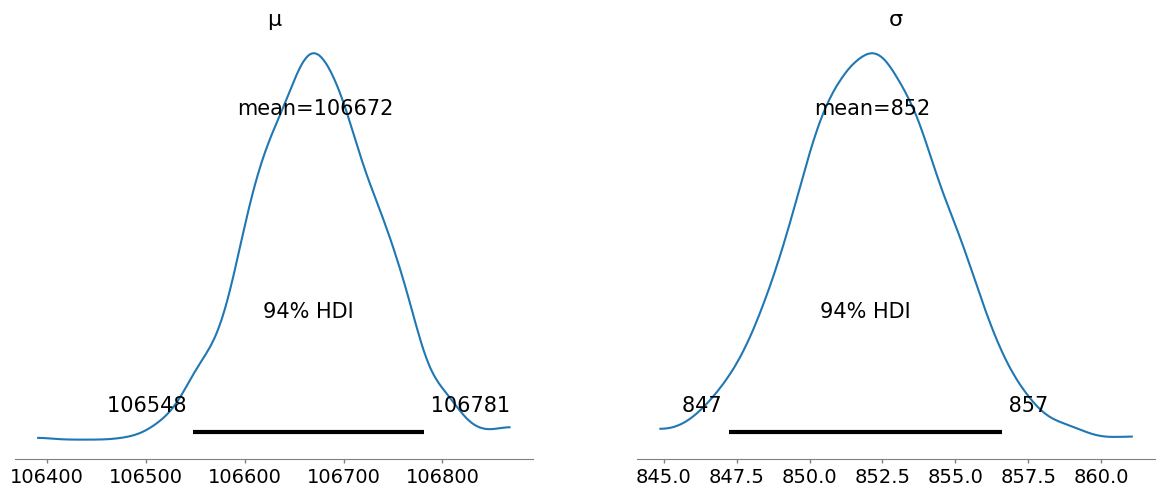

In [56]:
az.plot_posterior(idata_bitcoin)

In [ ]:
pm.sample_posterior_predictive(idata_bitcoin, model=model_Bitcoin, extend_inferencedata=True)

<Axes: xlabel='Y'>

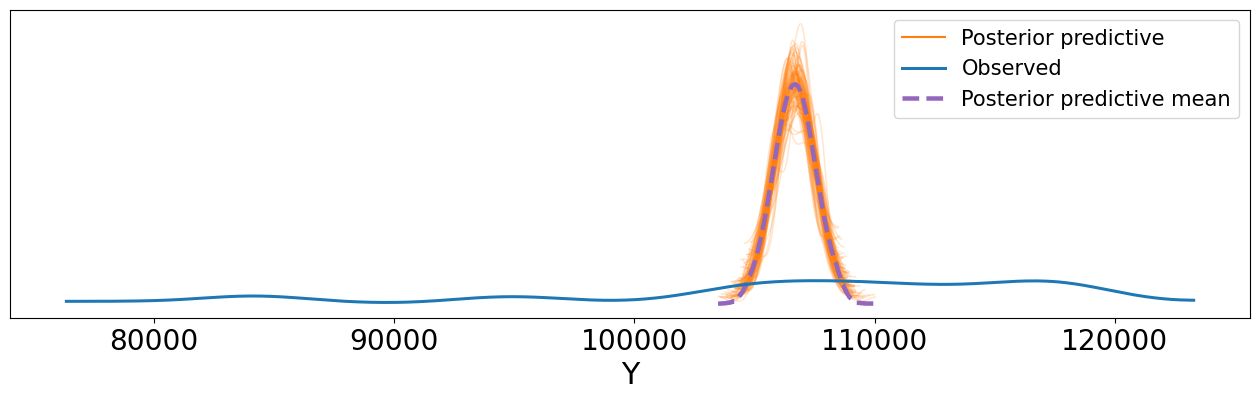

In [58]:
az.plot_ppc(idata_bitcoin, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C4"])

Initial model results: the posterior model don't match up too well with the observed at all, therefore this model isn't accurate. This is because this model dosen't take into account the "humps" in the model and how flat it is.

In [ ]:
with pm.Model() as model_Bitcoin:
    # Priors for the means of the component Normal distributions
    # We are assuming four components, and placing uniform priors on their means
    # Setting initial values for the means to help the sampler align with observed peaks
    mu1 = pm.Uniform('mu1', lower=dataFinal_numeric.min(), upper=dataFinal_numeric.max(), initval=85000)
    mu2 = pm.Uniform('mu2', lower=dataFinal_numeric.min(), upper=dataFinal_numeric.max(), initval=95000)
    mu3 = pm.Uniform('mu3', lower=dataFinal_numeric.min(), upper=dataFinal_numeric.max(), initval=105000)
    mu4 = pm.Uniform('mu4', lower=dataFinal_numeric.min(), upper=dataFinal_numeric.max(), initval=118000)


    # Priors for the standard deviations of the component Normal distributions
    # Using HalfNormal priors for standard deviations, which must be non-negative
    sigma1 = pm.HalfNormal('sigma1', sigma=10000) # Using a larger sigma for broader prior
    sigma2 = pm.HalfNormal('sigma2', sigma=10000)
    sigma3 = pm.HalfNormal('sigma3', sigma=10000)
    sigma4 = pm.HalfNormal('sigma4', sigma=10000)


    # Prior for the weights of the mixture components
    # Dirichlet prior ensures the weights are positive and sum to 1, for four components
    weights = pm.Dirichlet('weights', a=np.array([1, 1, 1, 1])) # Dirichlet prior for four components with equal initial weight

    # Component distributions
    # Defining the four Normal distributions that will make up the mixture
    comp_dists = [pm.Normal.dist(mu=mu1, sigma=sigma1),
                  pm.Normal.dist(mu=mu2, sigma=sigma2),
                  pm.Normal.dist(mu=mu3, sigma=sigma3),
                  pm.Normal.dist(mu=mu4, sigma=sigma4)]

    # Mixture likelihood
    # Combining the component distributions with the weights to form the likelihood
    Y = pm.Mixture('Y', w=weights, comp_dists=comp_dists, observed=dataFinal_numeric)

    idata_bitcoin_2 = pm.sample()

Instead of the normal distribution, I have switched my model to a Mixture distribution as out of all the preliz distributions on the gallery, the mixture distribution seemed to match up the most to my data.

The 4 uniform priors are utilized in order to account for the peaks/humps of the observed data.

The half normal priors are for the standard deviation which must be non negative.

My new prior I'm utilizing is the drichlet distribution prior, which models uncertainty over probability vectors. This helps encode prior beliefs about the spread or concentration of data through infeference.

For the final model I combine all the priors into the Mixture distribution in order to create the model.

In [ ]:
pm.sample_posterior_predictive(idata_bitcoin_2, model=model_Bitcoin, extend_inferencedata=True)

<Axes: xlabel='Y'>

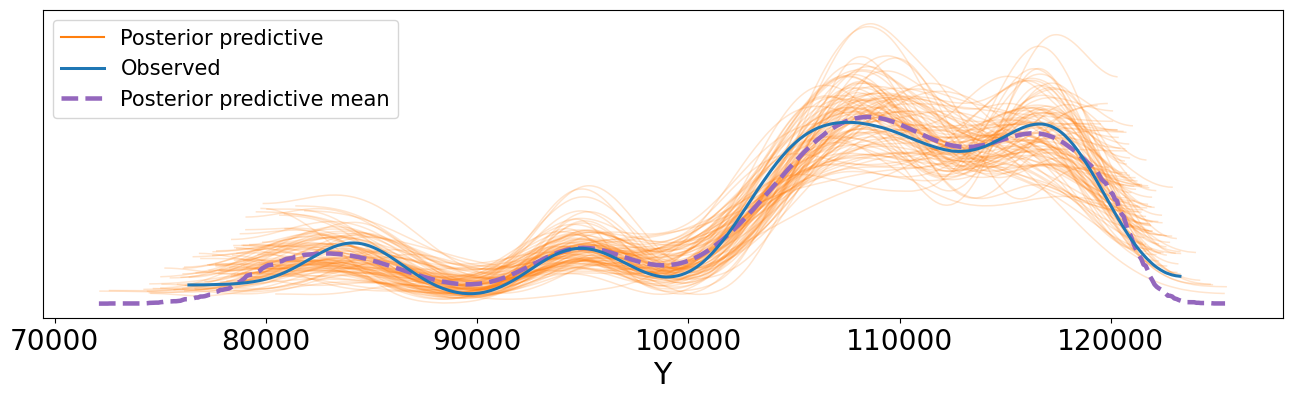

In [62]:
az.plot_ppc(idata_bitcoin_2, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C4"])

As we can see the new posterior predictive matches much better with the observed.

On this posterior, you can clearly see fluctuations in bitcoins price due to various factors. For example the surge to over 100k was driven by anticipation of a more crypto friendly environment regulation wise from Trump's administration. Additionally, the appointment of Paul Atkins (a cryptocurrency advocate) to lead the SEC contributed to increased market sentiment around cryptocurrency.

Credits:
Github @thedarredondo data-science-fundamentals/Unit3/Unit3NotesAK.ipynb for partial code

Google Gemini AI utilized for minor error fixes in collab.